In [ ]:
import pandas as pd
import os, cv2,itertools
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm

device = 'cuda'

In [ ]:
# Load the IMDb dataset
data_dir = '../input/movie-genre-prediction'
imdb_data = pd.read_csv('train.csv', sep=',')
imdb_data.head()
# Sample a portion of the shuffled dataset
imdb_data = imdb_data.sample(frac=1, random_state=123)

In [ ]:
imdb_data.count()
imdb_data['genre'].value_counts()

genre
horror       5400
mystery      5400
crime        5400
family       5400
thriller     5400
action       5400
scifi        5400
adventure    5400
romance      5400
fantasy      5400
Name: count, dtype: int64

In [ ]:
# Define a custom dataset class
class MovieGenreDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Define model parameters
MAX_LENGTH = 128
NUM_CLASSES = len(imdb_data["genre"].unique())  # Number of unique genres
LEARNING_RATE = 1e-6
BATCH_SIZE = 16
EPOCHS = 10

In [ ]:
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=NUM_CLASSES)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare data
train_df, test_df = train_test_split(imdb_data, test_size=0.2, stratify=imdb_data["genre"], random_state=123)
X_train, X_val, y_train, y_val = train_test_split(train_df["synopsis"], train_df["genre"], test_size=0.1, random_state=123)
train_dataset = MovieGenreDataset(X_train.values, LabelEncoder().fit_transform(y_train), tokenizer, MAX_LENGTH)
val_dataset = MovieGenreDataset(X_val.values, LabelEncoder().fit_transform(y_val), tokenizer, MAX_LENGTH)
test_dataset = MovieGenreDataset(test_df["synopsis"].values, LabelEncoder().fit_transform(test_df["genre"]), tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
train_df

,id,movie_name,synopsis,genre
48488,73104,Rogue Cell,When a contract killer discovers his latest se...,scifi
27899,86164,Bleeding,A bodyguard must protect the woman he has fall...,thriller
33961,66224,Hi How Are You?,"When, after one too many drinks in Paris, Lou ...",romance
16021,61636,Director,A struggle between a Director and an inspector...,mystery
31853,6138,South of 8,An ex-con trying to find work in a new Depress...,action
...,...,...,...,...
37633,12432,Only When I Larf,A master conman leads a pair of British accomp...,adventure
12408,41268,The Lord of the Rings,The Fellowship of the Ring embark on a journey...,fantasy
53922,53455,Satanic,Four friends on their way to Coachella stop of...,horror
47210,66353,Holiday Week,1952. Drama starring Leslie Dwyer and Lisa Dan...,romance


In [ ]:
# Check Data Shapes
sample = next(iter(train_loader))
inputs, labels = sample['input_ids'], sample['label']
print("Input shape:", inputs.shape)
print("Labels shape:", labels.shape)

Input shape: torch.Size([16, 128])
Labels shape: torch.Size([16])


In [ ]:
# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_predictions / total_predictions

    print(f"Epoch {epoch+1}:")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")

Epoch 1 Validation: 100%|██████████| 270/270 [00:10<00:00, 25.00it/s]


Epoch 1:
  Training Loss: 2.1482
  Validation Loss: 1.9217
  Validation Accuracy: 0.3336


Epoch 2 Validation: 100%|██████████| 270/270 [00:10<00:00, 24.94it/s]


Epoch 2:
  Training Loss: 1.8521
  Validation Loss: 1.7580
  Validation Accuracy: 0.3815


Epoch 3 Validation: 100%|██████████| 270/270 [00:10<00:00, 24.99it/s]


Epoch 3:
  Training Loss: 1.7371
  Validation Loss: 1.6997
  Validation Accuracy: 0.3900


Epoch 4 Validation: 100%|██████████| 270/270 [00:10<00:00, 25.09it/s]


Epoch 4:
  Training Loss: 1.6832
  Validation Loss: 1.6812
  Validation Accuracy: 0.3931


Epoch 5 Validation: 100%|██████████| 270/270 [00:10<00:00, 25.08it/s]


Epoch 5:
  Training Loss: 1.6460
  Validation Loss: 1.6654
  Validation Accuracy: 0.3961


Epoch 6 Validation: 100%|██████████| 270/270 [00:10<00:00, 25.00it/s]


Epoch 6:
  Training Loss: 1.6173
  Validation Loss: 1.6592
  Validation Accuracy: 0.3991


Epoch 7 Validation: 100%|██████████| 270/270 [00:10<00:00, 25.07it/s]


Epoch 7:
  Training Loss: 1.5894
  Validation Loss: 1.6543
  Validation Accuracy: 0.4056


Epoch 8 Validation: 100%|██████████| 270/270 [00:10<00:00, 25.06it/s]


Epoch 8:
  Training Loss: 1.5670
  Validation Loss: 1.6575
  Validation Accuracy: 0.4012


Epoch 9 Validation: 100%|██████████| 270/270 [00:10<00:00, 24.97it/s]


Epoch 9:
  Training Loss: 1.5401
  Validation Loss: 1.6624
  Validation Accuracy: 0.4030


Epoch 10 Validation: 100%|██████████| 270/270 [00:10<00:00, 24.84it/s]

Epoch 10:
  Training Loss: 1.5161
  Validation Loss: 1.6623
  Validation Accuracy: 0.4019


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        test_loss += loss.item()

        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions

print("Test Results:")
print(f"  Test Loss: {avg_test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")


Testing: 100%|██████████| 675/675 [00:27<00:00, 24.82it/s]

Test Results:
  Test Loss: 1.6803
  Test Accuracy: 0.4033


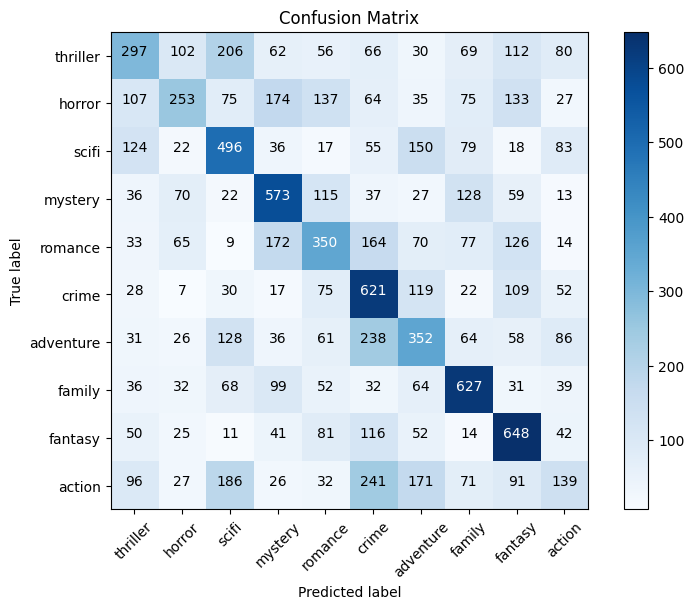

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

class_labels = ['thriller', 'horror', 'scifi', 'mystery', 'romance', 'crime', 'adventure', 'family', 'fantasy', 'action']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=class_labels, normalize=False, title='Confusion Matrix')
plt.show()

In [ ]:
# Calculate per-genre accuracy
genre_accuracy = {}
for i, genre in enumerate(class_labels):
    true_positives = cm[i, i]
    total_genre_samples = cm[i, :].sum()
    accuracy = true_positives / total_genre_samples
    genre_accuracy[genre] = accuracy

# Sort genres by accuracy
sorted_genre_accuracy = sorted(genre_accuracy.items(), key=lambda x: x[1], reverse=True)


print("\nRanked genres by accuracy:")
for rank, (genre, accuracy) in enumerate(sorted_genre_accuracy, 1):
    print(f"{rank}. {genre}: {accuracy:.4f}")


Ranked genres by accuracy:
1. fantasy: 0.6000
2. family: 0.5806
3. crime: 0.5750
4. mystery: 0.5306
5. scifi: 0.4593
6. adventure: 0.3259
7. romance: 0.3241
8. thriller: 0.2750
9. horror: 0.2343
10. action: 0.1287
